In [1]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from tfvmd.visualization.plotter import VMDVisualizer
from tfvmd.visualization.config import VisualizationConfig, FontConfig, LegendConfig, SaveConfig
from tfvmd.core.decomposition import TimeFrequencyVMD
from tfvmd.core.config import VMDConfig, BandwidthConfig
from ssqueezepy.experimental import scale_to_freq
from ssqueezepy import irfft, fftshift
from scipy.signal import istft
from scipy.ndimage import gaussian_filter
from matplotlib.gridspec import GridSpec

In [2]:
def generate_random():
    np.random.seed(7)
    N = 1024
    fs = 512
    signal = np.random.randn(N)
    signal = scipy.stats.zscore(signal)*0.5
    return signal, fs

In [3]:
def generate_signal():
    # Generate test signal
    N = 1024
    fs = 128
    t = np.arange(N)/fs
    np.random.seed(7)

    # Create multi-component signal
    seq = np.random.permutation(np.arange(8))
    def omega(t):
        return seq[np.floor(t).astype(int)] + 13
    # First two components are the same
    x1 = np.sin(2*np.pi*(omega(t))*t)
    x2 = 0.75*np.sin(2*np.pi*(1.75*omega(t))*t)

    # Third component only appears in certain time ranges
    x3 = 1.25*np.sin(2*np.pi*(2.5*omega(t))*t)  # Linear chirp signal
    mask = ((t >= 1.5) & (t <= 3.5)) | ((t >= 5.5) & (t <= 7.5))
    x3 = x3 * mask  # Apply mask to make x3 appear only in specific time ranges

    # Combined signal with noise
    signal = x1 + x2 + x3 + np.random.randn(N)*0.2
    return signal, fs

In [4]:
def main(signal, fs, method_band='adaptive', method_mode='dme', transform_type = 'stft', t_mode=[0,0.5,1]):
    # Configure bandwidth estimation
    config_bandw = BandwidthConfig(
        method=method_band,
        scale_factor=1.0,
        base_method='silverman',
        min_bandwidth=1e-6
    )

    # Configure VMD
    config_vmd = VMDConfig(
        num_channels=1,
        n_fft=fs//2,
        alpha=50,
        tol=1e-8,
        tau=0.00001,
        max_iterations=100,
        modulated=True,
        rho_thresh=0.0,
        method=method_mode,
        keep_residual=False
    )

    # Initialize VMD
    vmd = TimeFrequencyVMD(config_vmd, config_bandw)
    
    # Transform signal to TF domain
    signal_expanded = signal.reshape(1, -1)
    tf_map, scale = vmd.transformer.transform(signal_expanded, transform_type=transform_type)
    
    if transform_type=='cwt' or transform_type=='ssq_cwt':
        scale = scale_to_freq(scale, 'gmw', len(signal), fs=fs)
    # Decompose signal
    result = vmd.decompose(tf_map, t_modes=t_mode)
    # result = vmd.generate_time_domain_modes(result, transform_type)
    return result,vmd,scale

In [5]:
addfontsize = 4
# You can also customize base font sizes and then scale them
config = VisualizationConfig(
    base_fonts=FontConfig(
        base_font=12+addfontsize,
        base_title=14+addfontsize,
        base_label=12+addfontsize,
        base_tick=12+addfontsize,
        base_legend=10+addfontsize
    ),
    font_scale=1.2,  # These base sizes will be scaled by 1.2
    # tf_legend=LegendConfig(
    #     location='upper left'
    # ),
    centers_legend=LegendConfig(
        location='upper right',
        framealpha=0.7
    ),
    signal_legend=LegendConfig(
        location=(0.6, -0.02),  # Lower right
        ncol=2,
        frameon=False  # No frame
    ),
    save_config=SaveConfig(
        format='svg',
        transparent=True  # Transparent background
    )
)
visualizer = VMDVisualizer(config)

### Influence of Sample Rate

Selected decomposition method: dme


DME Processing: 100%|██████████| 1024/1024 [00:07<00:00, 140.47it/s]


Selected decomposition method: dme


DME Processing: 100%|██████████| 1024/1024 [00:02<00:00, 370.54it/s]


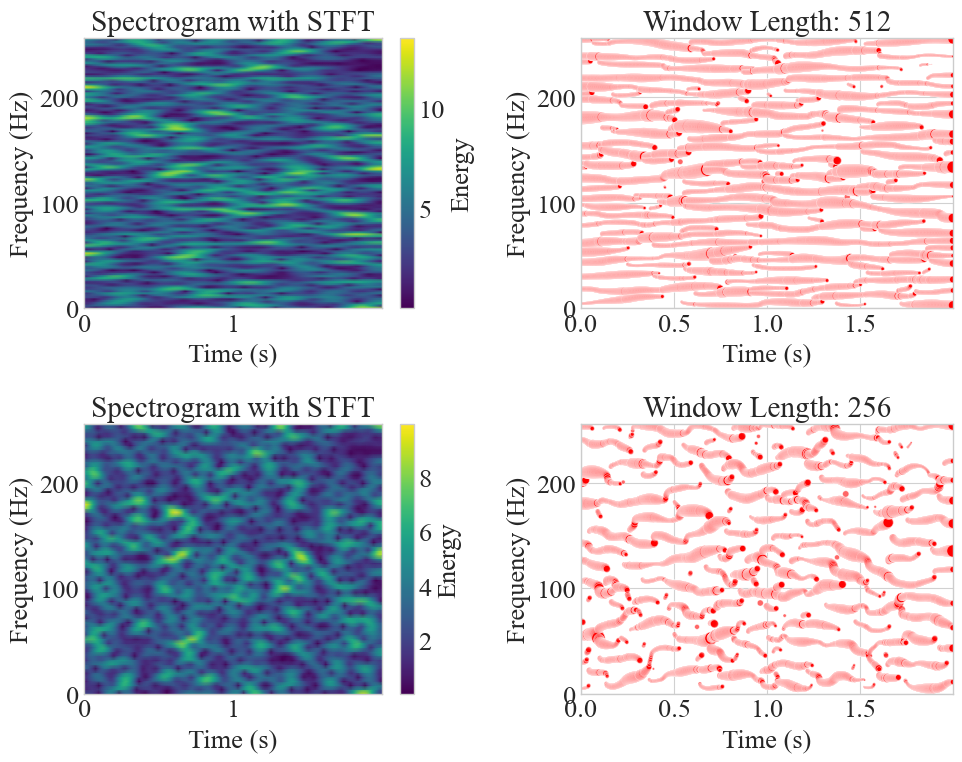

In [27]:
signal, fs = generate_random()

fig = plt.figure(figsize=(10, 8))
gs = GridSpec(2, 2)

result,vmd,scale = main(signal, fs//2**0, 
                            method_band='percentile', 
                            method_mode='dme', 
                            transform_type='stft')

ax_tf = fig.add_subplot(gs[0, 0])
visualizer._plot_tf_original(ax_tf, result, fs//2**0)
ax_tf.set_title('Spectrogram with STFT')
ax_tf_centers = fig.add_subplot(gs[0, 1])
visualizer._plot_tf_centers(ax_tf_centers, result, fs, title=f'Window Length: {fs//2**0}')


result,vmd,scale = main(signal, fs//2**1, 
                            method_band='percentile', 
                            method_mode='dme', 
                            transform_type='stft')
ax_tf = fig.add_subplot(gs[1, 0])
visualizer._plot_tf_original(ax_tf, result, fs//2**0)
ax_tf.set_title('Spectrogram with STFT')
ax_tf_centers = fig.add_subplot(gs[1, 1])
visualizer._plot_tf_centers(ax_tf_centers, result, fs, title=f'Window Length: {fs//2**1}')

# Adjust layout
plt.tight_layout()
fig.savefig('result_B1.png', format='png', dpi=300)

### Influence of Bandwidth Estimation

Selected decomposition method: dme


DME Processing: 100%|██████████| 1024/1024 [00:07<00:00, 140.50it/s]


Selected decomposition method: dme


DME Processing: 100%|██████████| 1024/1024 [00:06<00:00, 157.93it/s]


Selected decomposition method: dme


DME Processing: 100%|██████████| 1024/1024 [00:08<00:00, 122.06it/s]


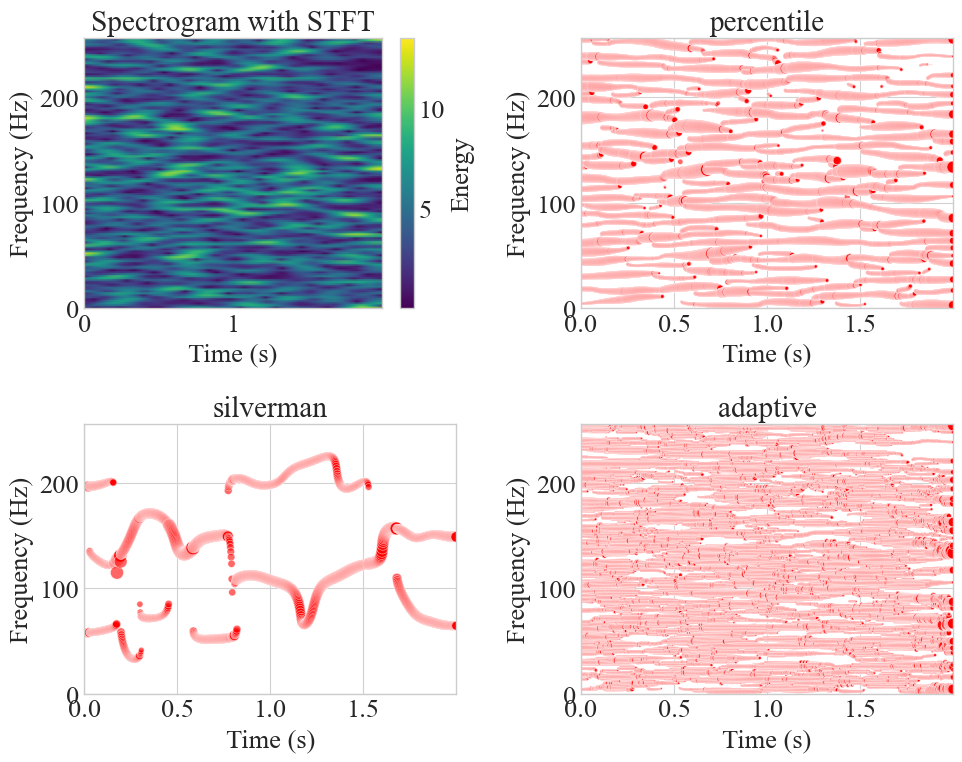

In [7]:
signal, fs = generate_random()

fig = plt.figure(figsize=(10, 8))
gs = GridSpec(2, 2)

result,vmd,scale = main(signal, fs, 
                            method_band='percentile', 
                            method_mode='dme', 
                            transform_type='stft')

ax_tf = fig.add_subplot(gs[0, 0])
visualizer._plot_tf_original(ax_tf, result, fs)
ax_tf.set_title('Spectrogram with STFT')
ax_tf_centers = fig.add_subplot(gs[0, 1])
visualizer._plot_tf_centers(ax_tf_centers, result, fs, title=f'percentile')


result,vmd,scale = main(signal, fs, 
                            method_band='silverman', 
                            method_mode='dme', 
                            transform_type='stft')
ax_tf_centers = fig.add_subplot(gs[1, 0])
visualizer._plot_tf_centers(ax_tf_centers, result, fs, title=f'silverman')

result,vmd,scale = main(signal, fs, 
                            method_band='adaptive', 
                            method_mode='dme', 
                            transform_type='stft')
ax_tf_centers = fig.add_subplot(gs[1, 1])
visualizer._plot_tf_centers(ax_tf_centers, result, fs, title=f'adaptive')

# Adjust layout
plt.tight_layout()
fig.savefig('result_B2.png', format='png', dpi=300)

Selected decomposition method: dme


DME Processing: 100%|██████████| 1024/1024 [00:00<00:00, 1397.43it/s]


Selected decomposition method: dme


DME Processing: 100%|██████████| 1024/1024 [00:00<00:00, 1811.79it/s]


Selected decomposition method: dme


DME Processing: 100%|██████████| 1024/1024 [00:00<00:00, 1437.98it/s]


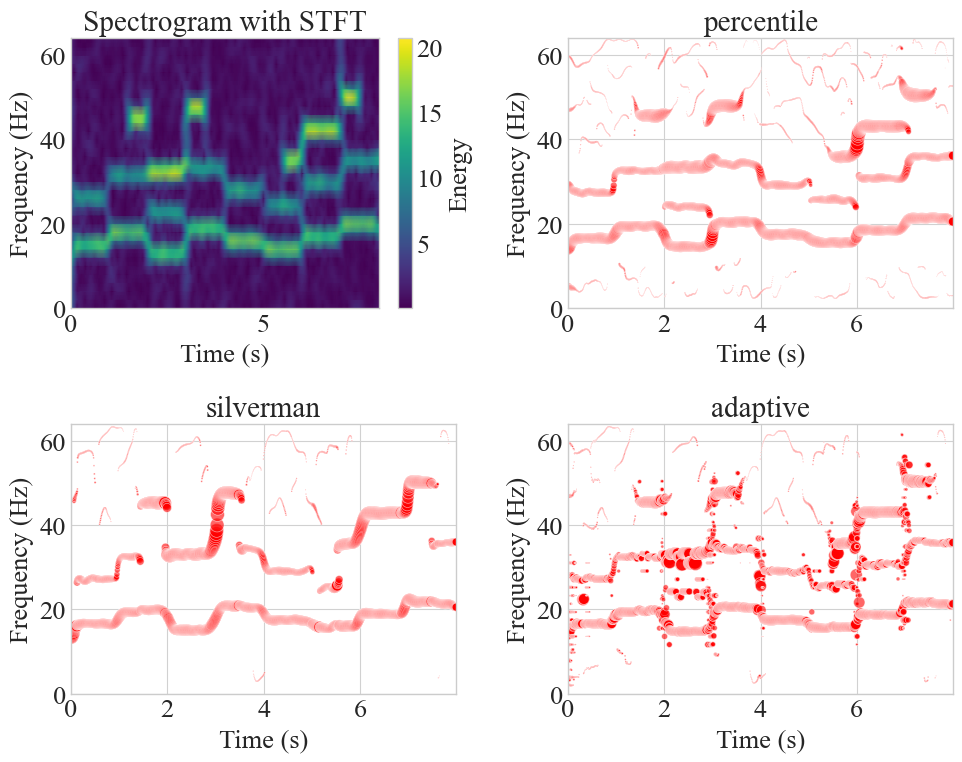

In [8]:
signal, fs = generate_signal()

fig = plt.figure(figsize=(10, 8))
gs = GridSpec(2, 2)

result,vmd,scale = main(signal, fs, 
                            method_band='percentile', 
                            method_mode='dme', 
                            transform_type='stft')

ax_tf = fig.add_subplot(gs[0, 0])
visualizer._plot_tf_original(ax_tf, result, fs)
ax_tf.set_title('Spectrogram with STFT')
ax_tf_centers = fig.add_subplot(gs[0, 1])
visualizer._plot_tf_centers(ax_tf_centers, result, fs, title=f'percentile')


result,vmd,scale = main(signal, fs, 
                            method_band='silverman', 
                            method_mode='dme', 
                            transform_type='stft')
ax_tf_centers = fig.add_subplot(gs[1, 0])
visualizer._plot_tf_centers(ax_tf_centers, result, fs, title=f'silverman')

result,vmd,scale = main(signal, fs, 
                            method_band='adaptive', 
                            method_mode='dme', 
                            transform_type='stft')
ax_tf_centers = fig.add_subplot(gs[1, 1])
visualizer._plot_tf_centers(ax_tf_centers, result, fs, title=f'adaptive')

# Adjust layout
plt.tight_layout()
fig.savefig('result_B3.png', format='png', dpi=300)

### Spectrogram

In [19]:
signal, fs = generate_random()
freq_points = np.linspace(0, fs/2, 237)

result_stft,vmd_stft,scale_stft = main(signal, fs, 
                            method_band='percentile', 
                            method_mode='dme', 
                            transform_type='stft')

result_sstft,vmd_sstft,scale_sstft = main(signal, fs, 
                            method_band='percentile', 
                            method_mode='dme', 
                            transform_type='ssq_stft')

result_cwt,vmd_cwt,scale_cwt = main(signal, fs, 
                            method_band='percentile', 
                            method_mode='dme', 
                            transform_type='cwt')

result_qcwt,vmd_qcwt,scale_qcwt = main(signal, fs, 
                            method_band='percentile', 
                            method_mode='dme', 
                            transform_type='ssq_cwt')

Selected decomposition method: dme


DME Processing: 100%|██████████| 1024/1024 [00:07<00:00, 141.61it/s]


Selected decomposition method: dme


DME Processing: 100%|██████████| 1024/1024 [00:05<00:00, 172.68it/s]


Selected decomposition method: dme


DME Processing: 100%|██████████| 1024/1024 [00:46<00:00, 22.21it/s]


Selected decomposition method: dme


DME Processing: 100%|██████████| 1024/1024 [00:13<00:00, 73.80it/s]


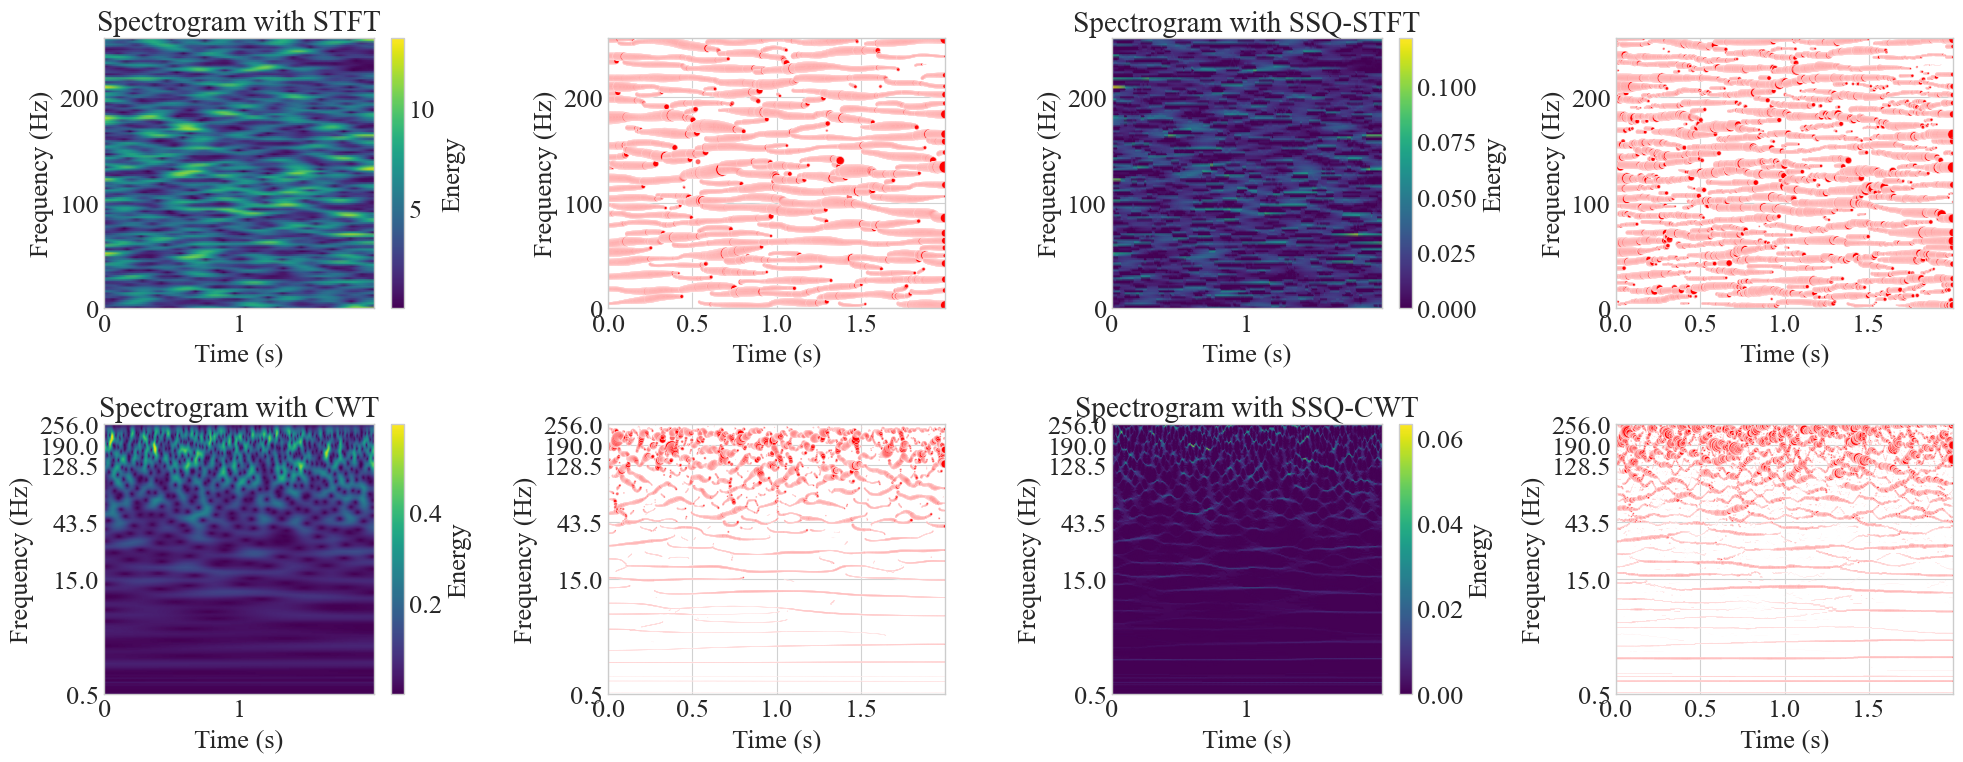

In [21]:
fig = plt.figure(figsize=(20, 8))
gs = GridSpec(2, 4)

ax_tf = fig.add_subplot(gs[0, 0])
visualizer._plot_tf_original(ax_tf, result_stft, fs)
ax_tf.set_title('Spectrogram with STFT')
ax_tf_centers = fig.add_subplot(gs[0, 1])
visualizer._plot_tf_centers(ax_tf_centers, result_stft, fs)

ax_tf = fig.add_subplot(gs[0, 2])
visualizer._plot_tf_original(ax_tf, result_sstft, fs)
ax_tf.set_title('Spectrogram with SSQ-STFT')
ax_tf_centers = fig.add_subplot(gs[0, 3])
visualizer._plot_tf_centers(ax_tf_centers, result_sstft, fs)

ax_tf = fig.add_subplot(gs[1, 0])
visualizer._plot_tf_original(ax_tf, result_cwt, fs)
ax_tf.set_title('Spectrogram with CWT')
ax_tf.set_yticks(freq_points[[0,100,150,200,218,236]])
ax_tf.set_yticklabels(scale_cwt[::-1][[0,100,150,200,218,236]])

ax_tf_centers = fig.add_subplot(gs[1, 1])
visualizer._plot_tf_centers(ax_tf_centers, result_cwt, fs)
ax_tf_centers.set_yticks(freq_points[[0,100,150,200,218,236]])
ax_tf_centers.set_yticklabels(scale_cwt[::-1][[0,100,150,200,218,236]])

ax_tf = fig.add_subplot(gs[1, 2])
visualizer._plot_tf_original(ax_tf, result_qcwt, fs)
ax_tf.set_title('Spectrogram with SSQ-CWT')
ax_tf.set_yticks(freq_points[[0,100,150,200,218,236]])
ax_tf.set_yticklabels(scale_qcwt[::-1][[0,100,150,200,218,236]])

ax_tf_centers = fig.add_subplot(gs[1, 3])
visualizer._plot_tf_centers(ax_tf_centers, result_qcwt, fs)
ax_tf_centers.set_yticks(freq_points[[0,100,150,200,218,236]])
ax_tf_centers.set_yticklabels(scale_qcwt[::-1][[0,100,150,200,218,236]])

# Adjust layout
plt.tight_layout()

In [22]:
fig.savefig('result_B4.png', format='png', dpi=300)

In [23]:
signal, fs = generate_signal()
freq_points = np.linspace(0, fs/2, 237)

result_stft,vmd_stft,scale_stft = main(signal, fs, 
                            method_band='percentile', 
                            method_mode='dme', 
                            transform_type='stft')

result_sstft,vmd_sstft,scale_sstft = main(signal, fs, 
                            method_band='percentile', 
                            method_mode='dme', 
                            transform_type='ssq_stft')

result_cwt,vmd_cwt,scale_cwt = main(signal, fs, 
                            method_band='percentile', 
                            method_mode='dme', 
                            transform_type='cwt')

result_qcwt,vmd_qcwt,scale_qcwt = main(signal, fs, 
                            method_band='percentile', 
                            method_mode='dme', 
                            transform_type='ssq_cwt')

Selected decomposition method: dme


DME Processing: 100%|██████████| 1024/1024 [00:00<00:00, 1320.70it/s]


Selected decomposition method: dme


DME Processing: 100%|██████████| 1024/1024 [00:00<00:00, 1357.79it/s]


Selected decomposition method: dme


DME Processing: 100%|██████████| 1024/1024 [00:47<00:00, 21.37it/s]


Selected decomposition method: dme


DME Processing: 100%|██████████| 1024/1024 [00:16<00:00, 62.44it/s]


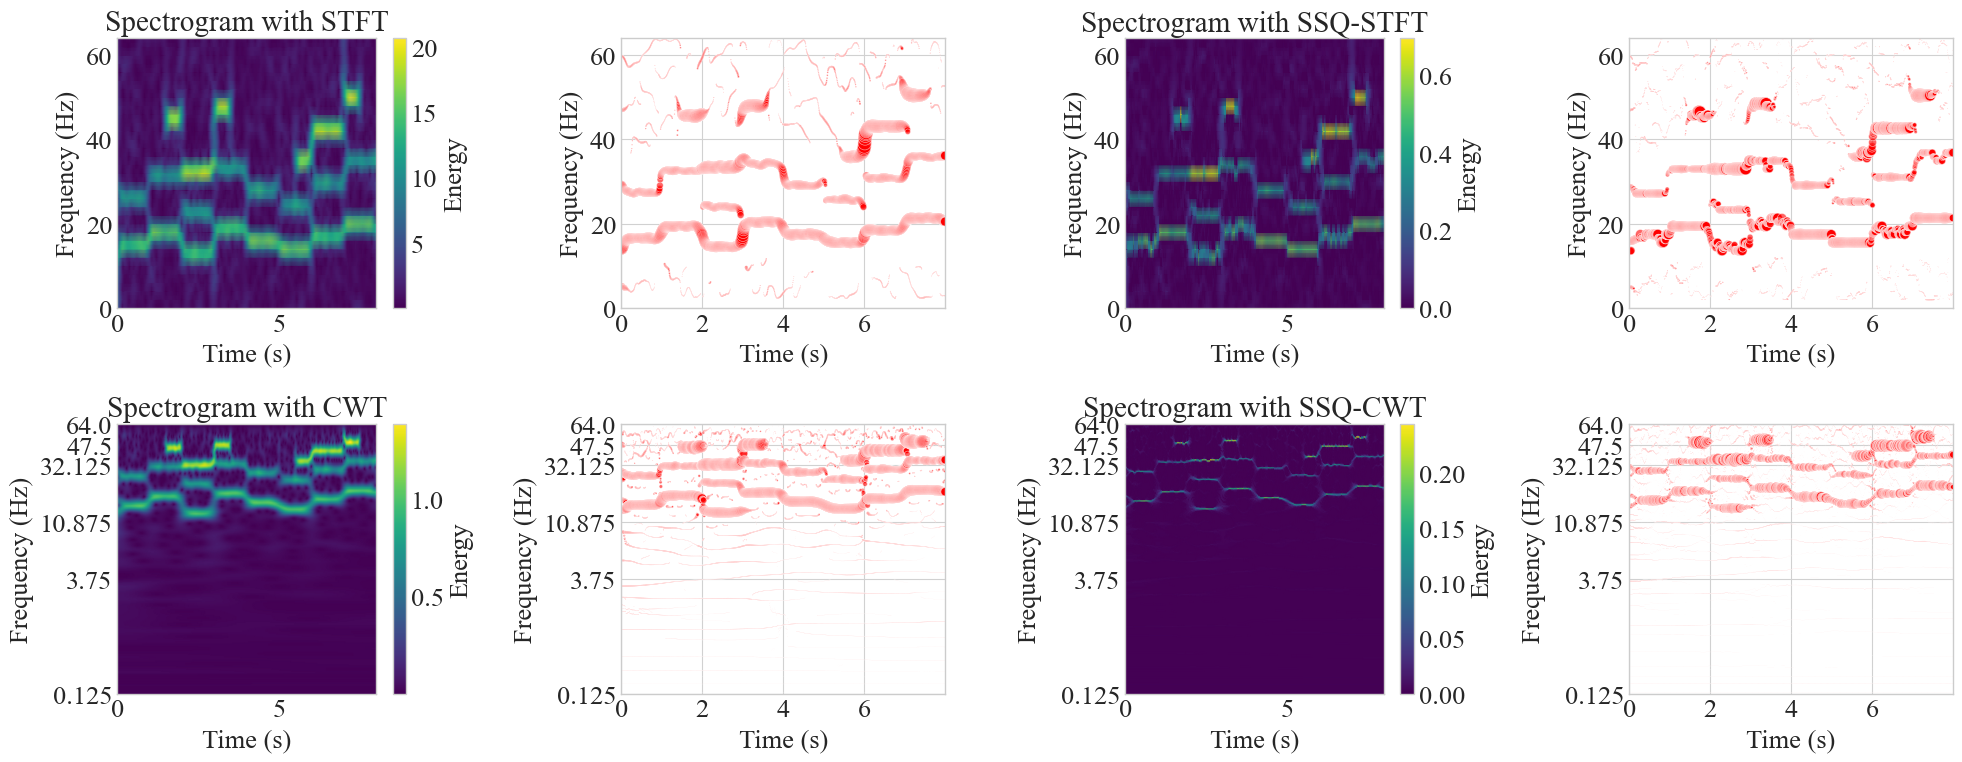

In [24]:
fig = plt.figure(figsize=(20, 8))
gs = GridSpec(2, 4)

ax_tf = fig.add_subplot(gs[0, 0])
visualizer._plot_tf_original(ax_tf, result_stft, fs)
ax_tf.set_title('Spectrogram with STFT')
ax_tf_centers = fig.add_subplot(gs[0, 1])
visualizer._plot_tf_centers(ax_tf_centers, result_stft, fs)

ax_tf = fig.add_subplot(gs[0, 2])
visualizer._plot_tf_original(ax_tf, result_sstft, fs)
ax_tf.set_title('Spectrogram with SSQ-STFT')
ax_tf_centers = fig.add_subplot(gs[0, 3])
visualizer._plot_tf_centers(ax_tf_centers, result_sstft, fs)

ax_tf = fig.add_subplot(gs[1, 0])
visualizer._plot_tf_original(ax_tf, result_cwt, fs)
ax_tf.set_title('Spectrogram with CWT')
ax_tf.set_yticks(freq_points[[0,100,150,200,218,236]])
ax_tf.set_yticklabels(scale[::-1][[0,100,150,200,218,236]])

ax_tf_centers = fig.add_subplot(gs[1, 1])
visualizer._plot_tf_centers(ax_tf_centers, result_cwt, fs)
ax_tf_centers.set_yticks(freq_points[[0,100,150,200,218,236]])
ax_tf_centers.set_yticklabels(scale[::-1][[0,100,150,200,218,236]])

ax_tf = fig.add_subplot(gs[1, 2])
visualizer._plot_tf_original(ax_tf, result_qcwt, fs)
ax_tf.set_title('Spectrogram with SSQ-CWT')
ax_tf.set_yticks(freq_points[[0,100,150,200,218,236]])
ax_tf.set_yticklabels(scale[::-1][[0,100,150,200,218,236]])

ax_tf_centers = fig.add_subplot(gs[1, 3])
visualizer._plot_tf_centers(ax_tf_centers, result_qcwt, fs)
ax_tf_centers.set_yticks(freq_points[[0,100,150,200,218,236]])
ax_tf_centers.set_yticklabels(scale[::-1][[0,100,150,200,218,236]])

# Adjust layout
plt.tight_layout()

In [25]:
fig.savefig('result_B5.png', format='png', dpi=300)